In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import os
import argparse
import time
from tqdm import trange
from tensorboardX import SummaryWriter
from collections import OrderedDict
from torchsummary import summary

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import RetinaMNIST
from medmnist import INFO, Evaluator

In [44]:
model = torchvision.models.resnet18(pretrained=False)
info = INFO["retinamnist"]
DataClass = getattr(medmnist, info['python_class'])
data_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])])
train_dataset = DataClass(split='train', transform=data_transform, download=True, as_rgb=True)


Using downloaded and verified file: /home/matthijs/.medmnist/retinamnist.npz


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 28, 28])
(28, 28, 3)


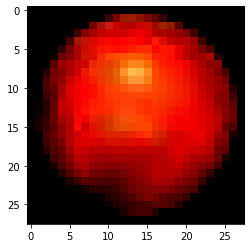

In [63]:
print((train_dataset)[0][0].shape)
print(np.array(train_dataset[10][0].T).shape)
plt.imshow(np.array(train_dataset[150][0].T))

In [51]:
with open("model.txt", "w") as fd:
    print(model, file=fd)

In [73]:
def train(model, train_loader, task, criterion, optimizer, device, writer):
    total_loss = []
    global iteration

    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # print(f"batch {batch_idx}:",model.conv1.weight.grad)
        compute_rc(model.conv1.weight.grad)
        optimizer.zero_grad()
        outputs = model(inputs.to(device))

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
        else:
            targets = torch.squeeze(targets, 1).long().to(device)
            loss = criterion(outputs, targets)

        total_loss.append(loss.item())
        writer.add_scalar('train_loss_logs', loss.item(), iteration)
        iteration += 1

        loss.backward()
        optimizer.step()
    
    epoch_loss = sum(total_loss)/len(total_loss)
    return epoch_loss

In [74]:
train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=128,
                            shuffle=True)
task = 'x'
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = 'cpu'
writer = SummaryWriter(log_dir=os.path.join("/home/matthijs/DataReconstruction/output_dir", 'Tensorboard_Results'))
iteration = 0
num_epochs = 10
for epoch in trange(num_epochs):
    train_loss = train(model, train_loader, task, criterion, optimizer, device, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

rc: 
rc: 
rc: 
rc: 
rc: 
rc: 
rc: 
rc: 
rc: 


 10%|█         | 1/10 [00:06<00:55,  6.19s/it]

rc: 


In [72]:
# Algorithm B1
def compute_rc(gradients):
    rc = gradients/gradients[0]
    print("rc: ",rc)
    return rc
